In [69]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from models import models_ddos

In [70]:
def loadDataset():
    # Put dataset path here ! 
    filename = 'pcap_data.csv'    

    trainfile = pd.read_csv(filename)    
    data = pd.DataFrame(trainfile).to_numpy()
    np.random.shuffle(data)
    
    X = data[:, :25]
    y = data[:, 25].astype('int32')  
 
    # MIN-MAX normalization
 
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)
    X = (X-xmin)/(xmax-xmin)
    
    # Train data 80% | Test data 15% | Validation data 5%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.25, stratify=y_test)

    return X_train.astype('float32'), y_train.astype('int32'), \
           X_val.astype('float32'), y_val.astype('int32'), \
           X_test.astype('float32'), y_test.astype('int32')

In [71]:
nclass = 3

# -- LOAD DATA -----------------------------------------------------------------
X_train, y_trainn, X_val, y_valn, X_test, y_testn = loadDataset()
inshape = X_train.shape[1]

# to_categorical
y_train = to_categorical(y_trainn, nclass)
y_val = to_categorical(y_valn, nclass)
y_test = to_categorical(y_testn, nclass)

print('X_train.shape=', X_train.shape)
print('X_test.shape=',  X_test.shape)
print('X_val.shape=',  X_val.shape)


X_train.shape= (11973, 25)
X_test.shape= (2245, 25)
X_val.shape= (749, 25)


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - acc: 0.3393 - loss: 1.0976
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Epoch 1, Iteration 1, Totally blocked 0 connections
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5884 - loss: 1.0770
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1, Iteration 2, Totally blocked 0 connections
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6759 - loss: 1.0469
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1, Iteration 3, Totally blocked 0 connections
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7007 - loss: 1.0031
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1, Iteration 4, Totally blocked 0 connections
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.6959 - loss: 0.9382
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1, Iteration 5, Totally blocked 0 connections
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7271 - loss: 0.8947
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1, Iteration 6, Totally blocked 0 connections
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc:

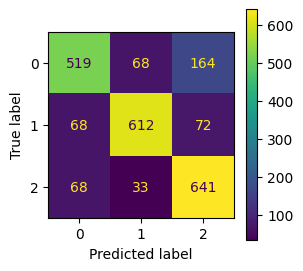

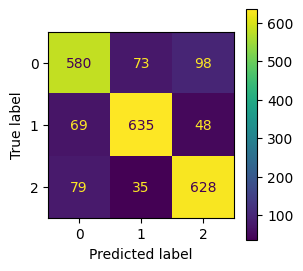

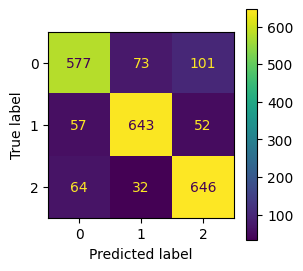

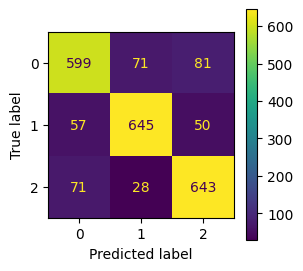

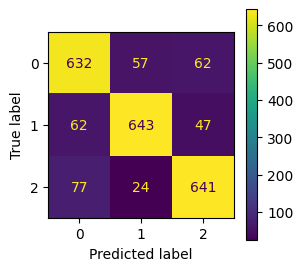

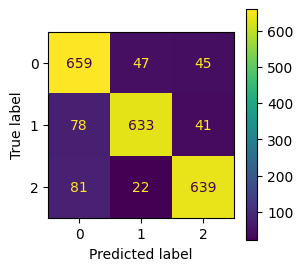

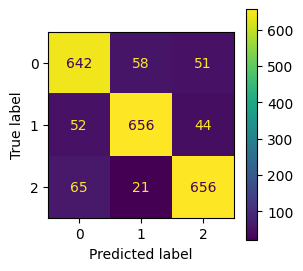

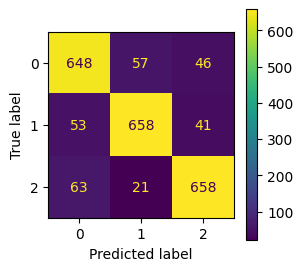

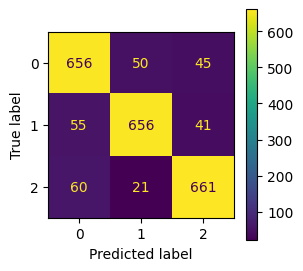

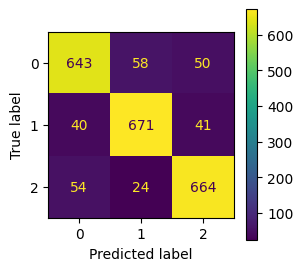

In [75]:
# Define malicious class and threshold proba

mal_class = 2
thresh_proba = 0.99

# Select best score CNN model

lr = 1e-4
N = 64
inshape = X_train.shape[1]

model = models_ddos.model_conv1D(lr=lr,N=N,inshape=inshape,nclass=nclass)

# Set number of epochs and batch size

number_of_epochs = 10
batch_size = 921

# Process model training through batches

for epoch in range(1, number_of_epochs + 1):

    for i in range(0, len(X_train), batch_size):
        
        iteration = int(i / batch_size + 1)

        X_batch = X_train[i : i + batch_size]
        y_batch = y_train[i : i + batch_size]

        model.fit(X_batch, y_batch)

        pred = model.predict(X_test)
        y_pred = pred.argmax(axis=-1)

        blocked_indices = []
        for k in range(pred.shape[0]):
            max_class = np.argmax(pred[k])
            max_proba = pred[k, max_class]
            if max_class == mal_class and max_proba > thresh_proba:
                blocked_indices.append([k, max_proba])
                print(f"Epoch {epoch}, Iteration {iteration}, Blocked malicious connection {k} with probability {"{:.4f}".format(max_proba)}")

        print(f"Epoch {epoch}, Iteration {iteration}, Totally blocked {len(blocked_indices)} connections")
    
    # Epoch results

    print(f"Summary results for epoch {epoch}:")
    
    matrix = confusion_matrix(y_testn.astype('int32'), y_pred)
    accuracy = accuracy_score(y_testn.astype('int32'), y_pred)
    print(f'Accuracy = {"{:.4f}".format(accuracy)}')

    label = [0, 1, 2]
    cmo = ConfusionMatrixDisplay(matrix, display_labels=label)
    fig, ax = plt.subplots(figsize=(3, 3))
    cmo.plot(ax=ax)
